In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
# theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import corner
from scipy.signal import savgol_filter

In [2]:
import xoflares #  the flares code

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.2.4.dev69+gc063778
1.0.4
3.8


In [4]:
lcf = lk.search_lightcurvefile('LTT 1445').download()

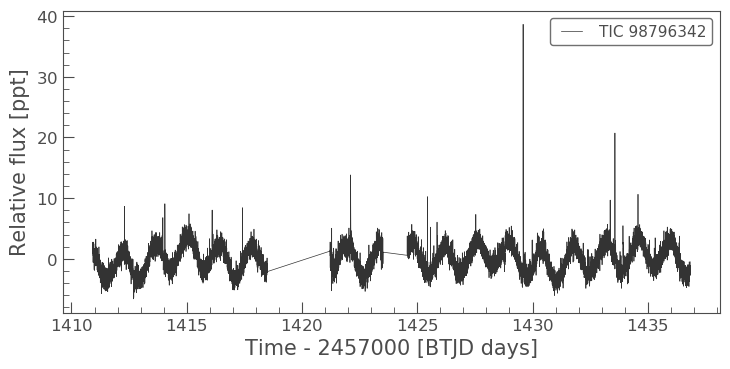

In [5]:
lc = lcf.get_lightcurve('PDCSAP_FLUX').remove_nans().normalize()

lc.flux = (lc.flux - 1.0)  * 1e3
texp = lcf.hdu[1].header['FRAMETIM'] * lcf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lcf.time.min() + lcf.time.max())

lc.plot(normalize=False, ylabel='Relative flux [ppt]')

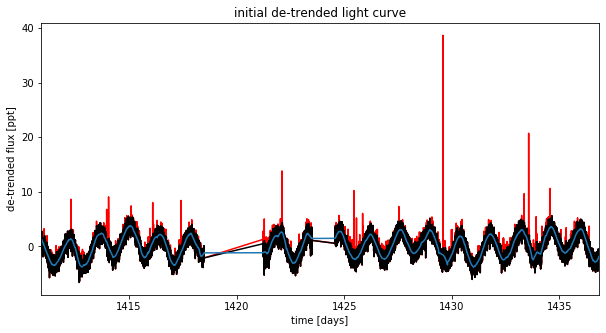

In [6]:
# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 301, polyorder=2)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [7]:
# find some flares
mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
cads = lc.cadenceno - lc.cadenceno[0]
x = lc.time - ref_time
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
npts = np.array([])
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            npts = np.r_[npts, n+1]
            i += 1
            n = 1
    except IndexError:
        npts = np.r_[npts, n+1]
        break
tpeaks = np.array([x[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.array([resid[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
fwhms = np.asarray(npts) * (2/1440)
npeaks = np.shape(tpeaks)[0]
print(npeaks)

27


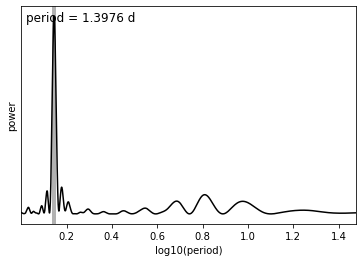

In [8]:
y = lc.flux
yerr = lc.flux_err * 1e3

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [9]:
scaling_constant = 1.8227218325582693
EDs_d = ampls *(fwhms * scaling_constant)
fwhms_d = fwhms
tpeaks_d = tpeaks

a = 2
mconst = np.min(EDs_d)

In [10]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        BoundedNormal = pm.Bound(pm.Normal, lower=0)
        xval = pm.Data('xval', x[mask])
        data = pm.Data('data', y[mask])
        data_err = pm.Data('data_err', yerr[mask])
        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

#        prior on the flare energies, loglike of pareto dist
        logalpha = pm.Normal('logalpha', mu=np.log(a), sd=1, testval=np.log(a))
        alpha = pm.Deterministic('alpha', tt.exp(logalpha))
        
#         BoundedNormal2 = pm.Bound(pm.Normal, upper=tt.max(ED_days))
#         m = BoundedNormal2('m', mu=mconst, sd=1, testval=mconst)
        m = pm.Deterministic('m', tt.as_tensor_variable(0.01))
        ED_days = pm.Pareto('ED_days', alpha=alpha, m=m, shape=npeaks, testval=EDs_d)
        
        tpeak = pm.Normal("tpeak", mu=tpeaks_d, sd=0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=tt.log(fwhms_d), sd=0.1, testval=tt.log(fwhms_d),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        
        ampl = pm.Deterministic("ampl", ED_days / (fwhm * scaling_constant))
     
        light_curve = xoflares.get_light_curve(xval, tpeak, fwhm, ampl, oversample=7, texp=None)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, xval, data_err**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(data - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: [logs2, mean]
9it [00:04,  2.02it/s, logp=-2.262843e+04]
message: Optimization terminated successfully.
logp: -22692.611069420156 -> -22628.42814520547
optimizing logp for variables: [logw, logS, logs2, mean]
132it [00:05, 24.07it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -22628.42814520547 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mean, logFwhm]
112it [00:04, 26.66it/s, logp=-2.233751e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -22628.42814520547 -> -22337.09484233418
optimizing logp for variables: [mean, ED_days, logFwhm]
91it [00:04, 21.86it/s, logp=-2.147274e+04]
message: Optimization terminated successfully.
logp: -22337.09484233418 -> -21472.736231609295
optimizing logp for variables: [ED_days, logFwhm]
2it [00:02,  1.20s/it, logp=-2.147274e+04]
message: Optimi

In [11]:
model, map_soln1 = build_model(mask=None, start=map_soln0)

optimizing logp for variables: [logs2, mean]
9it [00:02,  3.89it/s, logp=-2.115428e+04]
message: Optimization terminated successfully.
logp: -21154.29005846761 -> -21154.28120349901
optimizing logp for variables: [logw, logS, logs2, mean]
13it [00:02,  5.32it/s, logp=-2.115428e+04]
message: Optimization terminated successfully.
logp: -21154.28120349901 -> -21154.279618981946
optimizing logp for variables: [mean, logFwhm]
63it [00:03, 18.51it/s, logp=-2.115430e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -21154.279618981946 -> -21154.272877760348
optimizing logp for variables: [mean, ED_days, logFwhm]
89it [00:03, 22.27it/s, logp=-2.115427e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -21154.272877760348 -> -21154.272662790198
optimizing logp for variables: [ED_days, logFwhm]
52it [00:03, 15.49it/s, logp=-2.115430e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -21154.272662790198 

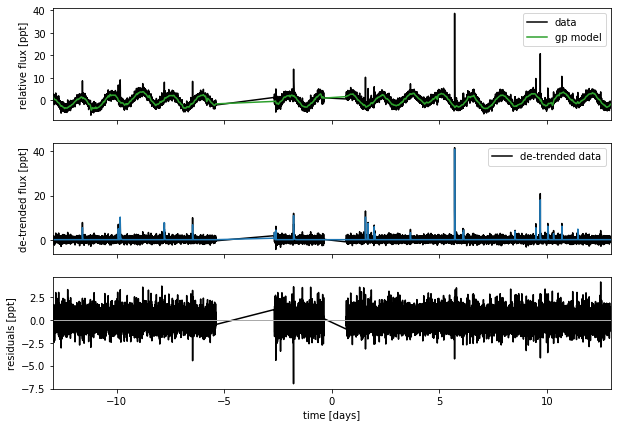

In [12]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curve, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model, map_soln1);

In [13]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)

optimizing logp for variables: [logFwhm, tpeak, ED_days, logalpha, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
97it [00:05, 17.53it/s, logp=-2.115541e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -21153.574083454252 -> -21153.574083454252


In [14]:
with model:

    trace = pm.sample(tune=1500, draws=1000, start=map_soln2, chains=4,
#                       step=xo.get_dense_nuts_step(target_accept=0.9),
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logFwhm, tpeak, ED_days, logalpha, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [6:42:08<00:00,  2.41s/draws]     
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
pm.summary(
    trace, var_names=["logalpha", "mean", "alpha", 'logperiod']
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logalpha,-0.086,0.188,-0.446,0.254,0.003,0.003,4613.0,2014.0,4706.0,2541.0,1.0
mean,0.001,0.248,-0.448,0.509,0.004,0.005,3753.0,1479.0,4021.0,1926.0,1.0
alpha,0.934,0.174,0.636,1.283,0.003,0.002,4812.0,4729.0,4706.0,2541.0,1.0
logperiod,0.335,0.001,0.332,0.336,0.000,0.000,1655.0,1655.0,2535.0,1459.0,1.0


/Users/tsbarcl2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


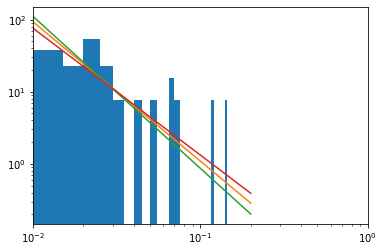

In [36]:
from scipy.stats import pareto

plt.hist(np.mean(trace['ED_days'], axis=0), bins=np.arange(0,0.2,0.005), normed=True);
v = np.arange(0.01, 0.2, 0.0001)
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha']), scale=0.01))
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha'])+np.std(trace['alpha']), scale=0.01))
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha'])-np.std(trace['alpha']), scale=0.01))

plt.xlim(0.01,1)

plt.yscale('log')
plt.xscale('log')

(0.012498626593778048, 0.04123396947092317)

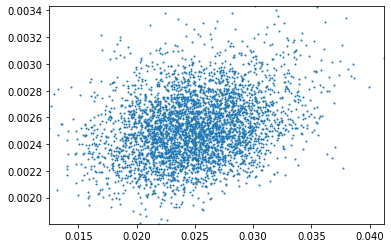

In [63]:
i=19
plt.scatter(trace['ED_days'][:, i], trace['fwhm'][:, i], s=1)

plt.ylim(np.min(trace['fwhm'][:, i]), np.max(trace['fwhm'][:, i]))
plt.xlim(np.min(trace['ED_days'][:, i]), np.max(trace['ED_days'][:, i]))

(0.010002604041340372, 0.02983597195681397)

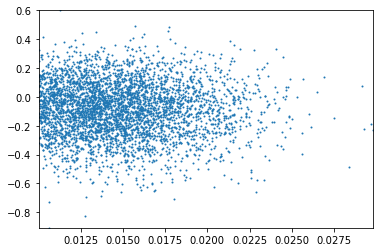

In [81]:
i=15
plt.scatter(trace['ED_days'][:, i], trace['logalpha'], s=1)

plt.ylim(np.min(trace['logalpha']), np.max(trace['logalpha']))
plt.xlim(np.min(trace['ED_days'][:, i]), np.max(trace['ED_days'][:, i]))